<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats
import seaborn as sns

import pylab as plt

In [2]:
# datos
df = pd.read_csv('data/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [5]:
# transformacion
lista = []
for x in df.version:
    if x == 'gate_30':
        lista.append('control')
    else:
        lista.append('treatment')
df.version = lista

In [6]:
pd.crosstab(df.version, df.retention_1), pd.crosstab(df.version, df.retention_7)

(retention_1  False   True
 version                  
 control      24666  20034
 treatment    25370  20119,
 retention_7  False  True
 version                 
 control      36198  8502
 treatment    37210  8279)

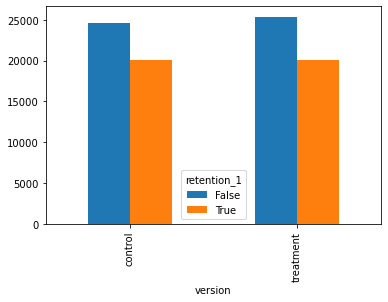

In [7]:
pd.crosstab(df.version, df.retention_1).plot(kind = 'bar');

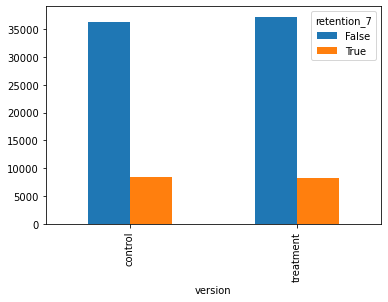

In [8]:
pd.crosstab(df.version, df.retention_7).plot(kind = 'bar');

In [9]:
# muestreo
control=df[df.version=='control'].sample(n=44700, random_state=22)

tratamiento=df[df.version=='treatment'].sample(n=44700, random_state=22)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,control,45,True,False
1,3589138,control,21,True,False
2,3177668,control,14,True,False
3,2133884,control,26,False,False
4,492763,control,39,True,True


In [10]:
ab_test.version.value_counts()

control      44700
treatment    44700
Name: version, dtype: int64

In [11]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo


std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
control,0.448,0.497,0.002
treatment,0.442,0.497,0.002


In [12]:
tasas_conversion2=ab_test.groupby('version')['retention_7']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion2=tasas_conversion2.agg([np.mean, std, error_std])
tasas_conversion2.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion2.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
control,0.190,0.392,0.002
treatment,0.182,0.386,0.002


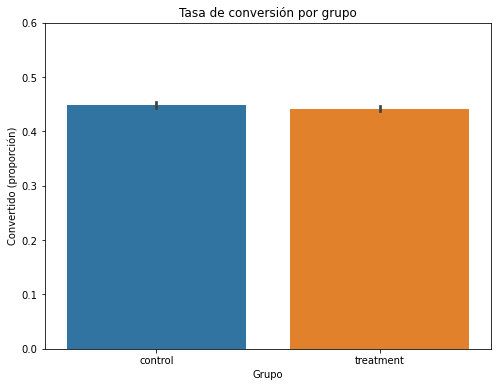

In [13]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0, 0.6)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

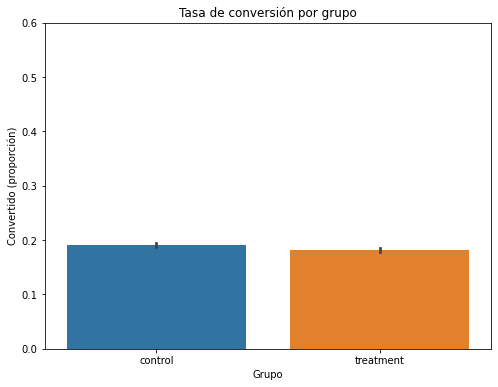

In [14]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0, 0.6)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [15]:
# testeo para retention_1
control_res=ab_test[ab_test.version=='control']['retention_1']

trat_res=ab_test[ab_test.version=='treatment']['retention_1']

In [16]:
observaciones=[44700, 44700]

conversiones=[control_res.sum(), trat_res.sum()]

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

In [17]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.85
p-valor: 0.064
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.437, 0.447]


In [18]:
# testeo para retention_7
control_res2=ab_test[ab_test.version=='control']['retention_7']

trat_res2=ab_test[ab_test.version=='treatment']['retention_7']

conversiones2=[control_res2.sum(), trat_res2.sum()]

z_score2, p_valor2 = proportions_ztest(conversiones2, nobs=observaciones)

(control_a2, trata_a2), (control_b2, trata_b2) = proportion_confint(conversiones2, 
                                                                nobs=observaciones,
                                                                alpha=0.05)
print(f'z-score: {z_score2:.2f}')
print(f'p-valor: {p_valor2:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a2:.3f}, {control_b2:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{trata_a2:.3f}, {trata_b2:.3f}]')

z-score: 3.19
p-valor: 0.001
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.178, 0.185]


In [19]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
tasas_conversion, tasas_conversion2

(           conversion_rate       std  std_error
 version                                        
 control           0.448188  0.497308   0.002352
 treatment         0.442036  0.496629   0.002349,
            conversion_rate       std  std_error
 version                                        
 control           0.190201  0.392460   0.001856
 treatment         0.181902  0.385763   0.001825)

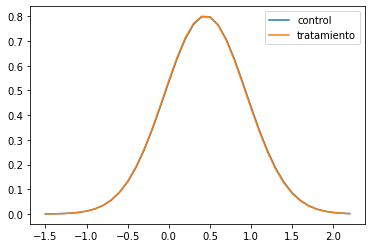

In [20]:
x=[i*.1 for i in range(-15, 23)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

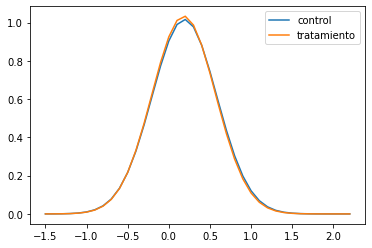

In [21]:
x=[i*.1 for i in range(-15, 23)]  

control2=[norm.pdf(x, tasas_conversion2.iloc[0][0], tasas_conversion2.iloc[0][1]) for x in x] 

tratamiento2=[norm.pdf(x, tasas_conversion2.iloc[1][0], tasas_conversion2.iloc[1][1]) for x in x] 

plt.plot(x, control2)
plt.plot(x, tratamiento2)
plt.legend(['control', 'tratamiento']);

In [22]:
#Conclusiones
'''
Dado que el p_valor=0.064 es mayor que alpha = 0.05 para la retencion 1, no podemos rechazar la hipótesis nula H_0, 
lo que significa que no hay diferencia en el primer dia en poner la puerta al nivel 30 que en el nivel 40.

En cambio en la retention_7 el p_valor=0.001 es menor que alpha = 0.05, por lo que rechazamos H_0,
lo que nos dice es que si hay una diferencia significativa entre la puerta al nivel 30 que en el 40.

A los 7 dias con la puerta al nivel 40 perdemos un 1-2 % de interactividad respecto al nivel 30.
'''

'\nDado que el p_valor=0.064 es mayor que alpha = 0.05 para la retencion 1, no podemos rechazar la hipótesis nula H_0, \nlo que significa que no hay diferencia en el primer dia en poner la puerta al nivel 30 que en el nivel 40.\n\nEn cambio en la retention_7 el p_valor=0.001 es menor que alpha = 0.05, por lo que rechazamos H_0,\nlo que nos dice es que si hay una diferencia significativa entre la puerta al nivel 30 que en el 40.\n\nA los 7 dias con la puerta al nivel 40 perdemos un 1-2 % de interactividad respecto al nivel 30.\n'

In [23]:
lista = [1,2,3,4]
lista2 = [1,2,3,4]
lista[-2]

3

In [26]:
lista*lista2

NameError: name 'lista2' is not defined

In [25]:
help(np.dot)

Help on function dot in module numpy:

dot(...)
    dot(a, b, out=None)
    
    Dot product of two arrays. Specifically,
    
    - If both `a` and `b` are 1-D arrays, it is inner product of vectors
      (without complex conjugation).
    
    - If both `a` and `b` are 2-D arrays, it is matrix multiplication,
      but using :func:`matmul` or ``a @ b`` is preferred.
    
    - If either `a` or `b` is 0-D (scalar), it is equivalent to :func:`multiply`
      and using ``numpy.multiply(a, b)`` or ``a * b`` is preferred.
    
    - If `a` is an N-D array and `b` is a 1-D array, it is a sum product over
      the last axis of `a` and `b`.
    
    - If `a` is an N-D array and `b` is an M-D array (where ``M>=2``), it is a
      sum product over the last axis of `a` and the second-to-last axis of `b`::
    
        dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    Parameters
    ----------
    a : array_like
        First argument.
    b : array_like
        Second argument.
    out : 